In [314]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.decomposition import PCA

In [315]:
dataset = "HU"

In [316]:
df_means = pd.read_csv("master/output/cluster_means/%s_means.csv"%dataset)
df_emb = pd.read_csv("master/output/embeddings/%s_embedding.csv"%dataset)

In [317]:
with open('master/output/assignments/%s.json'%dataset) as json_file:  
    labels = json.load(json_file)

In [318]:
df_label = pd.DataFrame({"index" : list(labels.keys()), "label" : list(labels.values())}).set_index("index")
df_label.head()

,label
index,
0,19
1,29
2,31
3,3
4,7


#### PCA

In [320]:
# pca = PCA().fit(df_means.values)
# plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [321]:
# pca.explained_variance_ratio_

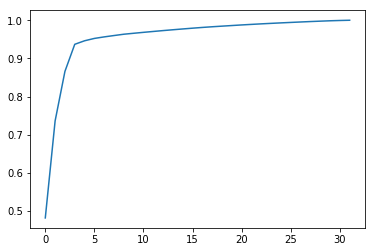

In [322]:
pca = PCA().fit(df_emb)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [323]:
sum(pca.explained_variance_ratio_[:3])

0.8658973126845073

In [324]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(df_emb)

In [325]:
projected.shape

(47538, 2)

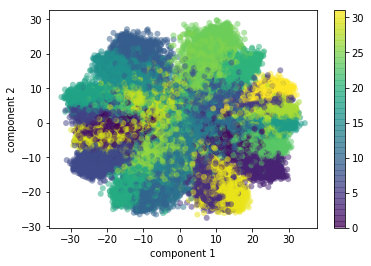

In [326]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=df_label.label, edgecolor='none', alpha=0.5, cmap='viridis')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Text(0, 0.5, 'component 2')

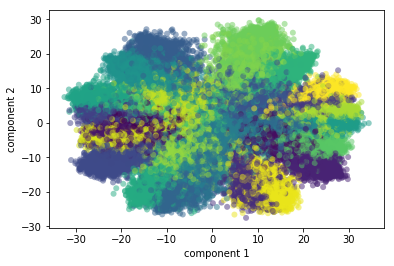

In [327]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=df_label.label, edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
# plt.colorbar();

In [328]:
pca = PCA(3)  # project from 64 to 2 dimensions
projected = pca.fit_transform(df_emb)

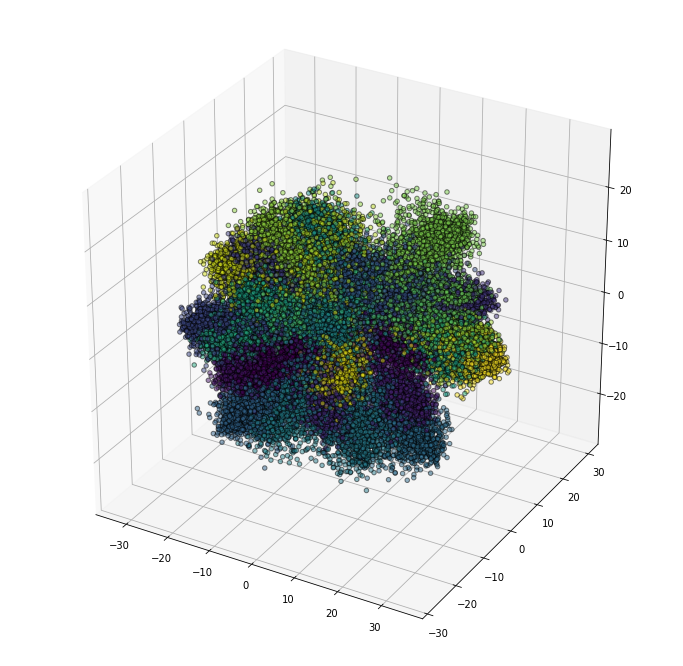

In [329]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(projected[:, 0], projected[:, 1], projected[:, 2],
            c=df_label.label, edgecolor='none', alpha=0.5)


#### Multi-dimensional Scaling

In [330]:
# from sklearn.manifold import MDS

In [331]:
# n_points = 200
# mds = MDS(n_components=2)
# emb_transformed = mds.fit_transform(df_emb[:n_points])
# emb_transformed.shape

# plt.scatter(emb_transformed[:, 0], emb_transformed[:, 1],
#             c=df_label[:n_points].label, edgecolor='none', alpha=0.5)
# plt.xlabel('component 1')
# plt.ylabel('component 2')
# # plt.colorbar();

In [332]:
# n_points = 500

# mds = MDS(n_components=3)
# emb_transformed = mds.fit_transform(df_emb[:n_points])
# emb_transformed.shape

# fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(emb_transformed[:, 0], emb_transformed[:, 1], emb_transformed[:, 2],
#             c=df_label[:n_points].label, edgecolor='none', alpha=0.5)

### Diffusion Modeling

In [333]:
from sklearn.metrics.pairwise import cosine_similarity

In [334]:
df_sim = cosine_similarity(df_emb, df_emb)
df_sim.shape

(47538, 47538)

In [336]:
df_edges = pd.read_csv("master/data/deezer_clean_data/%s_edges.csv"%dataset, index_col="node_1")

In [337]:
def lookup_neighbor(i):
    if i in df_edges.index:
        if len(df_edges.loc[i]) == 1:
            return [df_edges.loc[i].node_2]
        return df_edges.loc[i].node_2
    return []

In [338]:
seeds = [1]

for seed in seeds: 
    neighbors = lookup_neighbor(seed)
    for nei in neighbors:
        print(seed, nei, df_sim[seed, nei])

1 5463 0.7248175758314622
1 14232 0.9922557608838273
1 4833 0.9822202697303879
1 36852 0.8673080885352021
1 37620 0.9028622939607567


In [339]:
def simulate_diffusion(seeds, iteration=10):
    df_infected = df_label.copy()
    df_infected.index = df_infected.index.astype(int)
    df_infected["infected"] = False
    df_infected.loc[seeds, 'infected'] = True

    df_history = df_label.copy()
    df_history.index = df_history.index.astype(int)
    
    for i in range(iteration):
        df_infected_cur = df_infected[df_infected.infected==1].index
        for j, source in enumerate(df_infected_cur):
            
            df_history["i%i_f%i"%(i, j)] = df_infected.infected
            
            neighbors = lookup_neighbor(source)
            neighbors = list(filter(lambda x : df_sim[source, x] > np.random.rand(), neighbors))
            df_infected.loc[neighbors, 'infected'] = True
            
            if j % 100 == 0:
                print("iteration %i, progress %i/%i, infected %i (%.2f%%)     "
                      %(i, j, len(df_infected_cur), sum(df_infected.infected), 
                        100 * sum(df_infected.infected) / len(df_emb)), end="\r")
                
    return df_history, df_infected

##### Use Centroid in Each Cluster

In [181]:
target = 1

seeds = []

for target in range(20):
    centroid = df_means.loc[target]
    idxs = df_label[df_label.label == target].index
    df_cluster = df_emb.loc[list(map(int, idxs))]
    argmax = np.argmax(cosine_similarity(centroid.values.reshape(1, 16), df_cluster)[0])
    seeds.append(df_cluster.iloc[argmax].name)

df_history, df_infected = simulate_diffusion(seeds, iteration=10)

##### Random Seeds

In [341]:
n_seeds = 100
seeds = np.random.choice(df_emb.index, n_seeds)

df_history, df_infected = simulate_diffusion(seeds, iteration=2)

In [234]:
df_history.T.to_csv("output/%s_random.csv"%dataset)

##### Influencers

In [279]:
n_seeds = 100
df_influencer = df_edges.groupby("node_1").count()
seeds = df_influencer.sort_values(["node_2"], ascending=False)[:n_seeds].index.values

df_history, df_infected = simulate_diffusion(seeds, iteration=10)

In [285]:
df_sum = df_history.drop(["label"], axis=1).sum(axis=0)

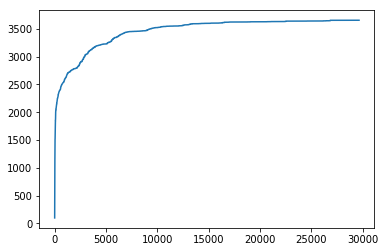

In [295]:
plt.plot(df_sum.values)

In [298]:
df_history.iloc[:, :5000].to_csv("output/%s_influencer.csv"%dataset)

##### Cluster Random Seeds

In [250]:
n_classes = len(np.unique(df_label.label))

In [251]:
for target in range(n_classes):
    print(target, "cluster size", sum(df_label.label==target))

0 cluster size 184
1 cluster size 319
2 cluster size 359
3 cluster size 154
4 cluster size 357
5 cluster size 238
6 cluster size 284
7 cluster size 205
8 cluster size 377
9 cluster size 203
10 cluster size 375
11 cluster size 330
12 cluster size 537
13 cluster size 552
14 cluster size 217
15 cluster size 163
16 cluster size 253
17 cluster size 249
18 cluster size 115
19 cluster size 437


In [255]:
seeds = []
n_seeds = 100
for target in range(n_classes):
    df_cluster = df_label[df_label.label==target]
    
    seeds += list(np.random.choice(df_cluster.index, int(n_seeds / n_classes)))

In [256]:
seeds = [int(i) for i in seeds]

In [257]:
df_history, df_infected = simulate_diffusion(seeds, iteration=10)

In [258]:
df_history.to_csv("output/%s_cluster_random.csv"%dataset)

#### Cluster Influencer

In [299]:
seeds = []
n_seeds = 100
for target in range(n_classes):
    idxs = df_label[df_label.label == target].index
    df_cluster = df_edges.iloc[list(map(int, idxs))]
    
    df_influencer = df_cluster.groupby("node_1").count()
    
    seeds += list(df_influencer.sort_values(["node_2"], ascending=False)[:int(n_seeds / n_classes)].index.values)

In [300]:
len(seeds)

100

In [268]:
df_history, df_infected = simulate_diffusion(seeds, iteration=10)

In [269]:
df_history.to_csv("output/%s_cluster_influencer.csv"%dataset)